# PHYS 434 - Lab 4

### Thomas K. Waters

In [246]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import h5py
import pandas as pd
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

plt.rcParams["figure.figsize"] = (15,10)

## Problem 1

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic ramean.

As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

#### 1) Download the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

In [3]:
hf = h5py.File('/Users/tw94/UW/PHYS_434/data/gammaray_lab4.h5', 'r')

In [4]:
data = np.array(hf.get('data'))

In [5]:
d = {'timeps': data[0], 'solar_phase': data[1], 'earth_long': data[2], 'counts': data[3]}
df = pd.DataFrame(data=d)

In [6]:
df

,time_gps,solar_phase,earth_long,counts
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


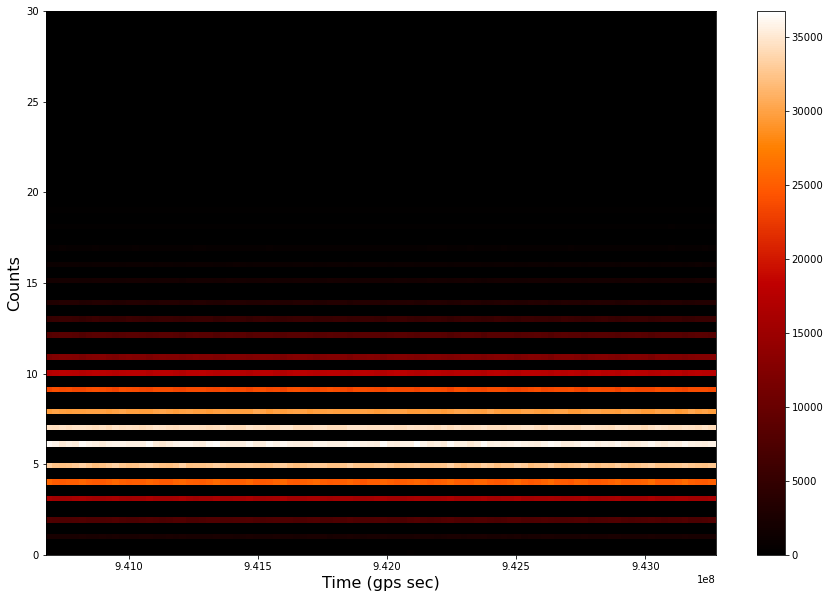

In [7]:
plt.hist2d(df['timeps'], df['counts'], bins = (100,100), cmap = 'gist_heat')
plt.xlabel('Time (gps sec)', size = 16)
plt.ylabel('Counts', size = 16)
plt.title
plt.colorbar()

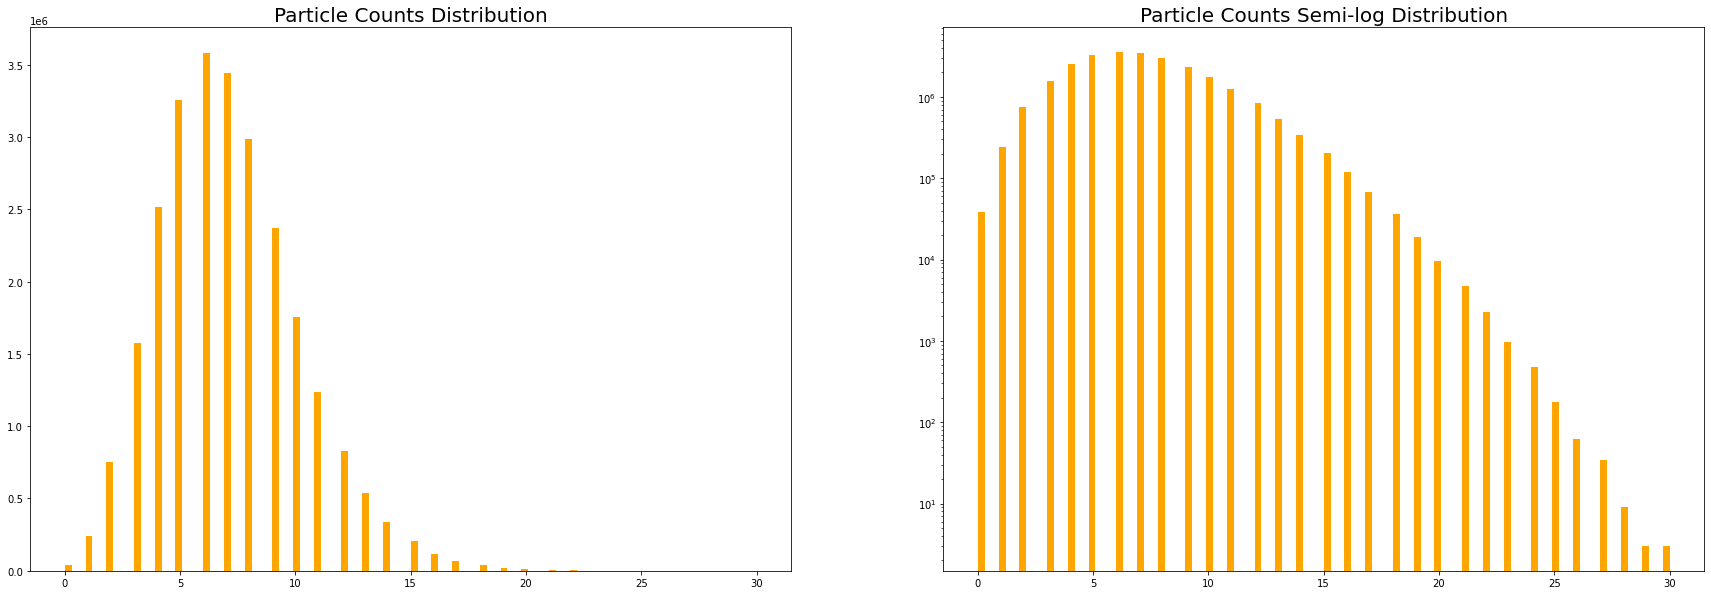

In [8]:
fig, ax = plt.subplots(1,2, figsize = (30,10))

ax[0].hist(df['counts'], bins = (100), color = 'orange')
ax[0].set_title('Particle Counts Distribution', size = 20)

ax[1].hist(df['counts'], bins = (100), color = 'orange')
ax[1].set_title('Particle Counts Semi-log Distribution', size = 20)
plt.yscale('log');

It appears that we have a Poisson distribution of particle counts. The distribution looks quite well behaved overall, but I do notice a slight excess of counts in the tail and some slight deviations from the standard Poisson PDF from about 25 to 30. I also made some plots showing the counts as a function of solar phase and longitude, but they weren't that illuminating so I removed them.

To build the background distribution, I plan to find the scale parameter of the above distribution and approximate it to a standard Poisson distribution. 

#### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

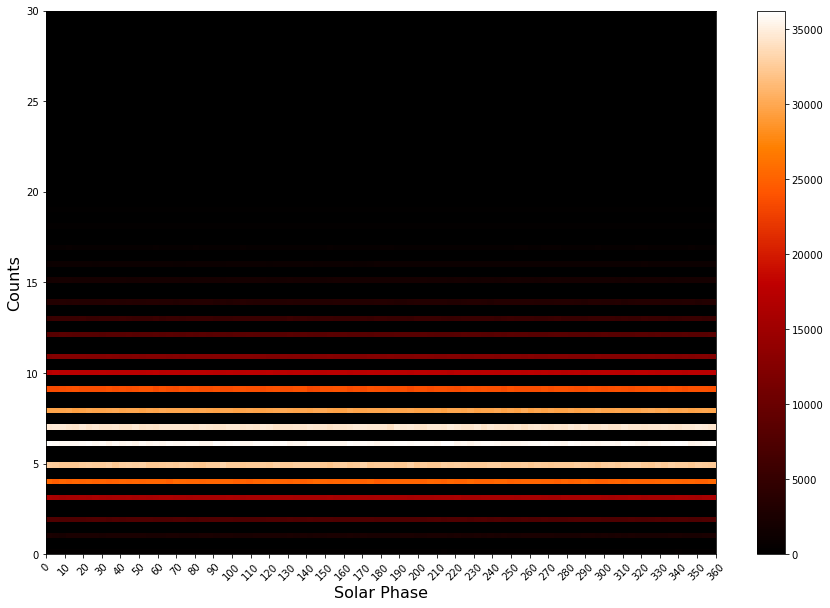

In [9]:
x = df['solar_phase']
y = df['counts']


h, xedges, yedges, image = plt.hist2d(x, y, bins = (100,100), cmap = 'gist_heat')
plt.xlabel('Solar Phase', size = 16)
plt.xticks(np.arange(min(x), max(x)+1, 10.0), rotation = 45)
plt.ylabel('Counts', size = 16)
plt.title
plt.colorbar();

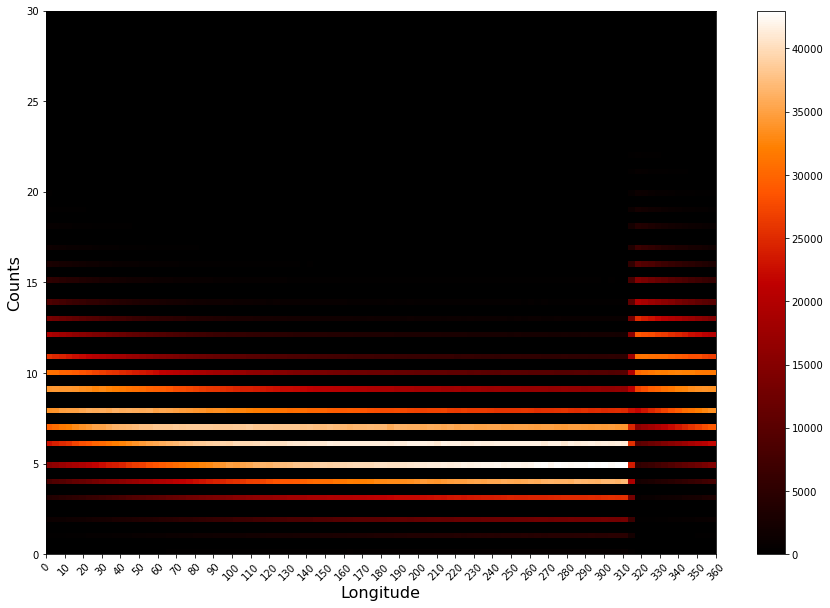

In [10]:
x = df['earth_long']
y = df['counts']


h, xedges, yedges, image = plt.hist2d(x, y, bins = (100,100), cmap = 'gist_heat')
plt.xlabel('Longitude', size = 16)
plt.xticks(np.arange(min(x), max(x)+1, 10.0), rotation = 45)
plt.ylabel('Counts', size = 16)
plt.title
plt.colorbar();

#### 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

What is the mean value as a function of longitude?

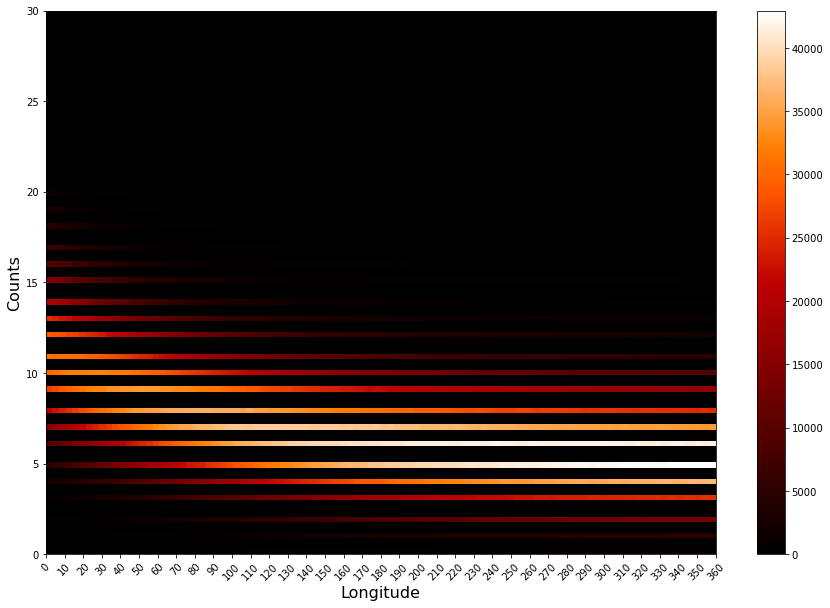

In [11]:
x = (df['earth_long'] + 45) % 360
y = df['counts']

h, xedges, yedges, image = plt.hist2d(x, y, bins = (100,100), cmap = 'gist_heat')
plt.xlabel('Longitude', size = 16)
plt.xticks(np.arange(min(x), max(x)+1, 10.0), rotation = 45)
plt.ylabel('Counts', size = 16)
plt.title
plt.colorbar();

In [12]:
mean = []
for i in range(54000):
    temp = np.mean(df['counts'][i::54000])
    mean.append(temp)

In [13]:
new_x = df['earth_long'][0:54000]

''

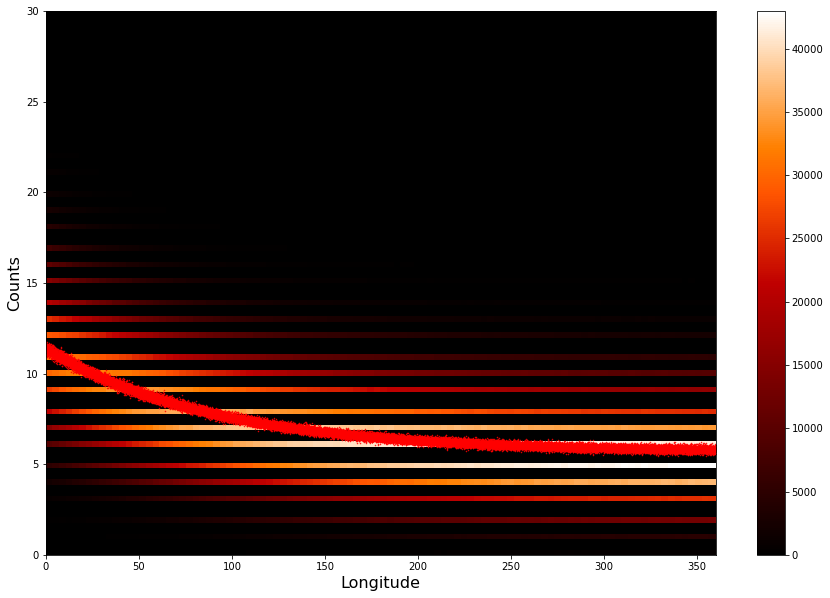

In [14]:
folded_x = (new_x + 45) % 360

h, xedges, yedges, image = plt.hist2d(x, y, bins = (100,100), cmap = 'gist_heat')
plt.xlabel('Longitude', size = 16)
plt.ylabel('Counts', size = 16)
plt.colorbar()
plt.scatter(folded_x, mean, s = 0.25, color = 'red')
;

In [15]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

R² = 0.9930108417793986
Y = 5.694199543494732 * e^(-0.01109860979950915 * x) + 5.698320445187339
Tau = 4505.068734123018 µs


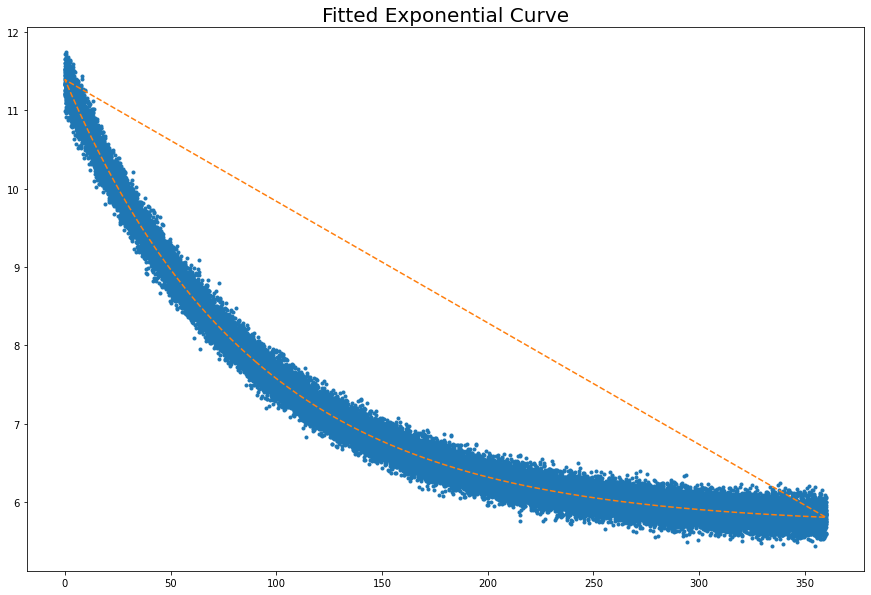

In [16]:
# perform the fit
p0 = (2000, .1, 50) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, folded_x, mean, p0)
m, t, b = params
sampleRate = 20_000 # Hz
tauSec = (1 / t) / sampleRate

# determine quality of the fit
squaredDiffs = np.square(mean - monoExp(folded_x, m, t, b))
squaredDiffsFromMean = np.square(mean - np.mean(mean))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# plot the results
plt.plot(folded_x, mean, '.', label="data")
plt.plot(folded_x, monoExp(folded_x, m, t, b), '--', label="fitted")
plt.title("Fitted Exponential Curve", size = 20)

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")
print(f"Tau = {tauSec * 1e6} µs")

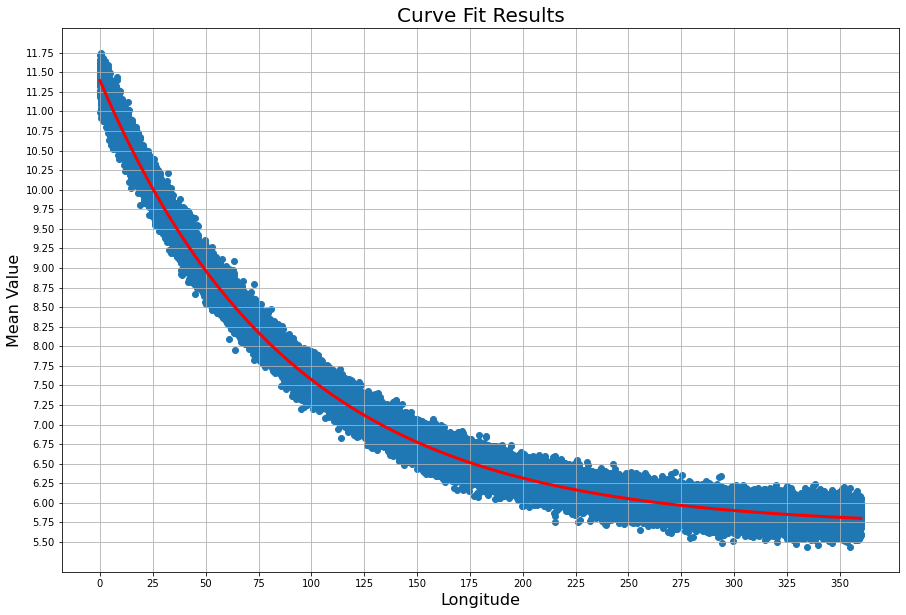

In [17]:
X = np.linspace(0, 360, num = len(mean))
Y = 5.694199543494732 * np.exp(-0.01109860979950915 * X) + 5.698320445187339
plt.scatter(folded_x, mean)
plt.plot(X, Y, color = 'red', linewidth = 3)
plt.title('Curve Fit Results', size = 20)
plt.xlabel('Longitude', size = 16)
plt.ylabel('Mean Value', size = 16)
plt.xticks(np.arange(0,360,25))
plt.yticks(np.arange(5.5,12,0.25))
plt.grid()

In [18]:
# Longitude Evolution Model:
model = Y # = 5.694199543494732 * np.exp(-0.01109860979950915 * X) + 5.698320445187339

#### Comparing the model to the data

For an arbitrary longitude, how does the data compare to a distribution generated from the mean value predicted by the model?

In [19]:
long = 150

In [79]:
mu = 6.75 #reading this from the plot above
k = np.arange(0,20,1)

poisson = stats.poisson.pmf(k, mu)
#poisson = stats.poisson.rvs(loc = 0, mu = mu, size = 10000)
counts = df[df['earth_long'] == long]['counts']

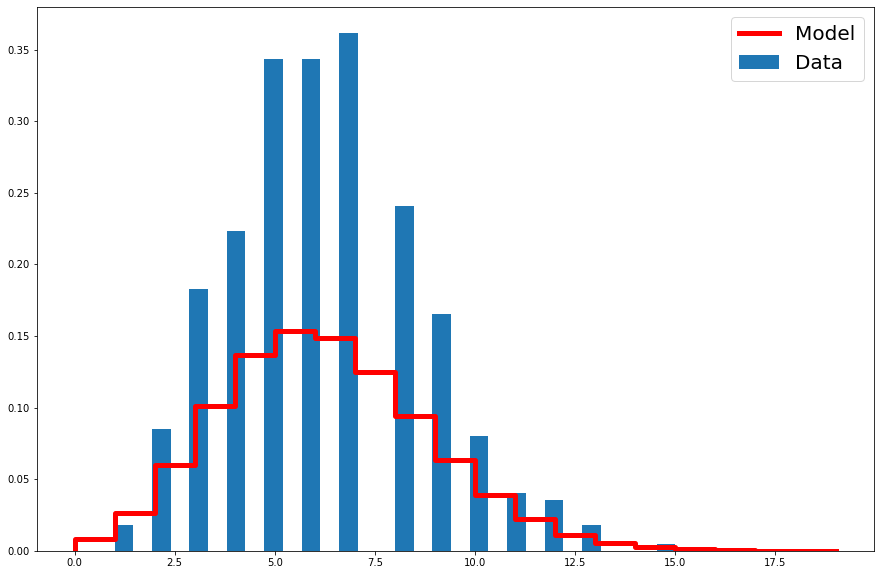

In [80]:
plt.hist(counts, bins = 30, density = True, label = 'Data')
plt.step(k, poisson, color = 'red', linewidth = 5, label = 'Model')
#plt.hist(poisson, color = 'red', bins = 30, density = True, label = 'Model')

plt.legend(prop={'size': 20})

While the model does produce a Poisson distribution with a mean value consistent with the data, the model underpredicts the total counts. Perhaps there is some level of noise in this contributing to the counts making the distribution not completely Poisson? It does not seem that the above data distribution will integrate to 1. Or perhaps the way I am plotting the theoretical distribution is incorect?

#### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [50]:
print(f'The 5 sigma threshold for a longitude of {25} degrees or {6.25} min into the orbital period is approximately {stats.poisson.isf((1/(3.5e6)), mu = 10.0)}.')

The 5 sigma threshold for a longitude of 25 degrees or 6.25 min into the orbital period is approximately 29.0.


In [51]:
print(f'The 5 sigma threshold for a longitude of {100} degrees or {25} min into the orbital period is approximately {stats.poisson.isf((1/(3.5e6)), mu = 7.5)}.')

The 5 sigma threshold for a longitude of 100 degrees or 25 min into the orbital period is approximately 25.0.


In [52]:
print(f'The 5 sigma threshold for a longitude of {175} degrees or {43.75} min into the orbital period is approximately {stats.poisson.isf((1/(3.5e6)), mu = 6.5)}.')

The 5 sigma threshold for a longitude of 175 degrees or 43.75 min into the orbital period is approximately 23.0.


In [53]:
print(f'The 5 sigma threshold for a longitude of {250} degrees or {62.5} min into the orbital period is approximately {stats.poisson.isf((1/(3.5e6)), mu = 6.25)}.')

The 5 sigma threshold for a longitude of 250 degrees or 62.5 min into the orbital period is approximately 22.0.


In [54]:
print(f'The 5 sigma threshold for a longitude of {325} degrees or {81.25} min into the orbital period is approximately {stats.poisson.isf((1/(3.5e6)), mu = 5.875)}.')

The 5 sigma threshold for a longitude of 325 degrees or 81.25 min into the orbital period is approximately 21.0.


## Problem 2
In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

#### 1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [184]:
images = h5py.File('/Users/tw94/UW/PHYS_434/data/images.h5')

In [185]:
list(images.keys())

['image1', 'imagestack']

In [186]:
dset = images['imagestack']
data = np.array(dset)

#### 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

In [187]:
np.shape(data)

(200, 200, 10)

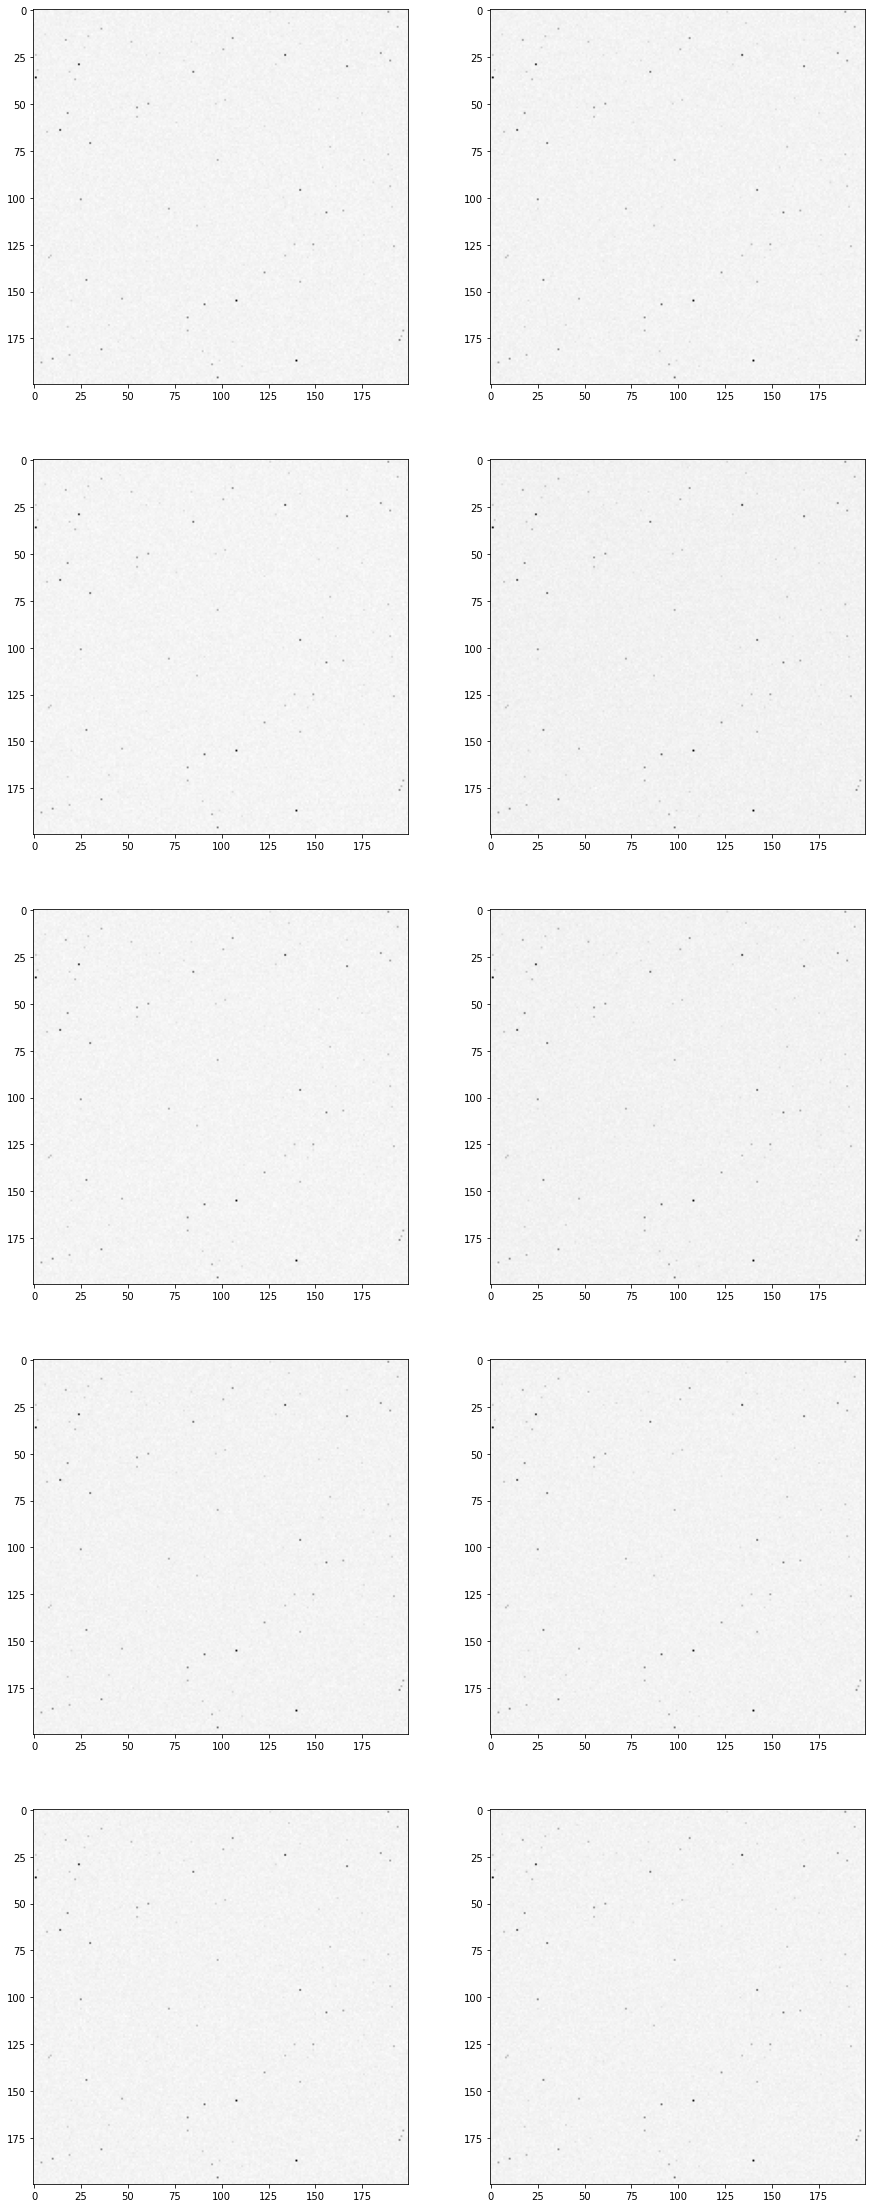

In [228]:
fig, ax = plt.subplots(5,2, figsize = (15,40))
ax[0,0].imshow(data[:,:, 0], cmap = 'gist_yarg')
ax[0,1].imshow(data[:,:, 1], cmap = 'gist_yarg')
ax[1,0].imshow(data[:,:, 2], cmap = 'gist_yarg')
ax[1,1].imshow(data[:,:, 3], cmap = 'gist_yarg')
ax[2,0].imshow(data[:,:, 4], cmap = 'gist_yarg')
ax[2,1].imshow(data[:,:, 5], cmap = 'gist_yarg')
ax[3,0].imshow(data[:,:, 6], cmap = 'gist_yarg')
ax[3,1].imshow(data[:,:, 7], cmap = 'gist_yarg')
ax[4,0].imshow(data[:,:, 8], cmap = 'gist_yarg')
ax[4,1].imshow(data[:,:, 9], cmap = 'gist_yarg')

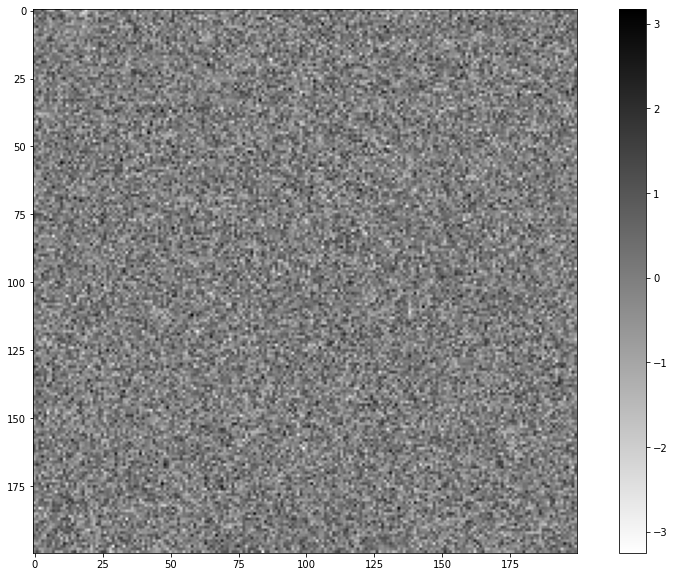

In [199]:
plt.imshow(data[:,:, 1] - data[:,:, 0], cmap = 'gist_yarg') #plotting the noise by subtracting 2 images.
plt.colorbar()

In [220]:
flatData = ((data[:,:, 1] - data[:,:, 0])).flatten() # Flattening noise to 1D array.
x = np.linspace(-4,4,1000)

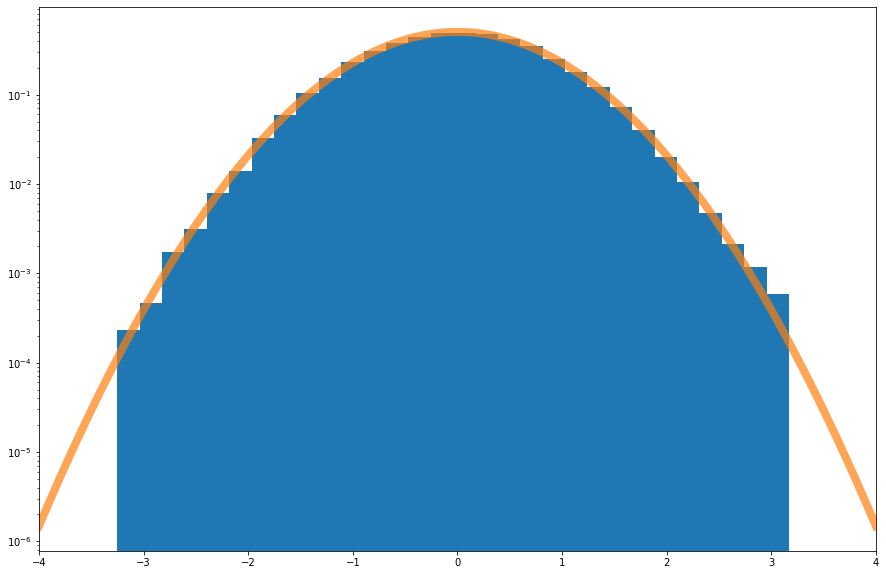

In [305]:
plt.hist(flatData, bins = 30, density = True)
plt.plot(x,stats.norm.pdf(x,loc = 0, scale = np.std(flatData)),linewidth = 8,alpha = 0.7)
plt.xlim(-4,4)
plt.yscale('log')

The noise is mostly gaussian. However, for some reason, the tails are cut off. In this case, our 5 sigma estimates based off of a normal gaussian distribution will be conservative estimates. This may be a biproduct of subtracting the images to obtain the noise. However, I think it is acceptable to assume a Gaussian distribution as we will not underestimate the 5 sigma threshold.

#### 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

In [306]:
stacked_img = (data[:,:, 0] + data[:,:, 1] + data[:,:, 2] + data[:,:, 3] + data[:,:, 4] 
               + data[:,:, 5] + data[:,:, 6] + data[:,:, 7] + data[:,:, 8] + data[:,:, 9])/10 #stacking all 10 images and taking the average

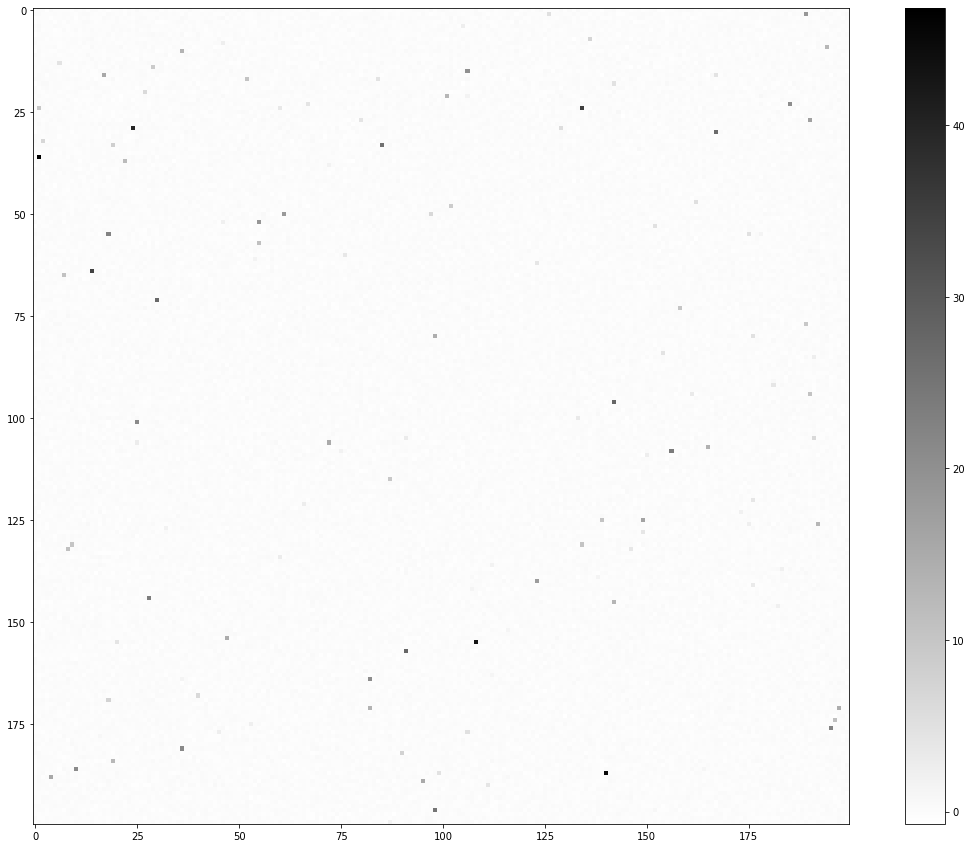

In [284]:
plt.figure(figsize = (20,15))
plt.imshow(stacked_img, cmap = 'gist_yarg')
plt.colorbar()

In [285]:
thresh = stats.norm.isf(1/3.5e6, loc = 0, scale = np.std(flatData)) # 5 sigma detection threshold

In [277]:
thresh

3.9631902924344686

In [297]:
n_stars = len(stacked_img[stacked_img > thresh]) #counting # of stars above the 5 sigma threshold.

In [299]:
print(f'The total number of stars above the 5 sigma threshold in the stacked image is {n_stars}.')

The total number of stars above the 5 sigma threshold in the stacked image is 86.


#### 4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

Unfortunately, due to the amount of time this lab took, I had minimal time to collaborate with my lab partner, so I do not know what their PDFs look like. However, since they are looking for transients, I would assume that the PDF will differ slightly between images which would affect the 5 sigma thresholds for each. 